In [1]:
library(rugarch)
library(tseries)

Loading required package: parallel


Attaching package: ‘rugarch’


The following object is masked from ‘package:stats’:

    sigma


Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 



In [2]:
# Load the data
load("Y.RData")

# Save the returns in a variable called y
y <- Y$AAPL
dates <- Y$date

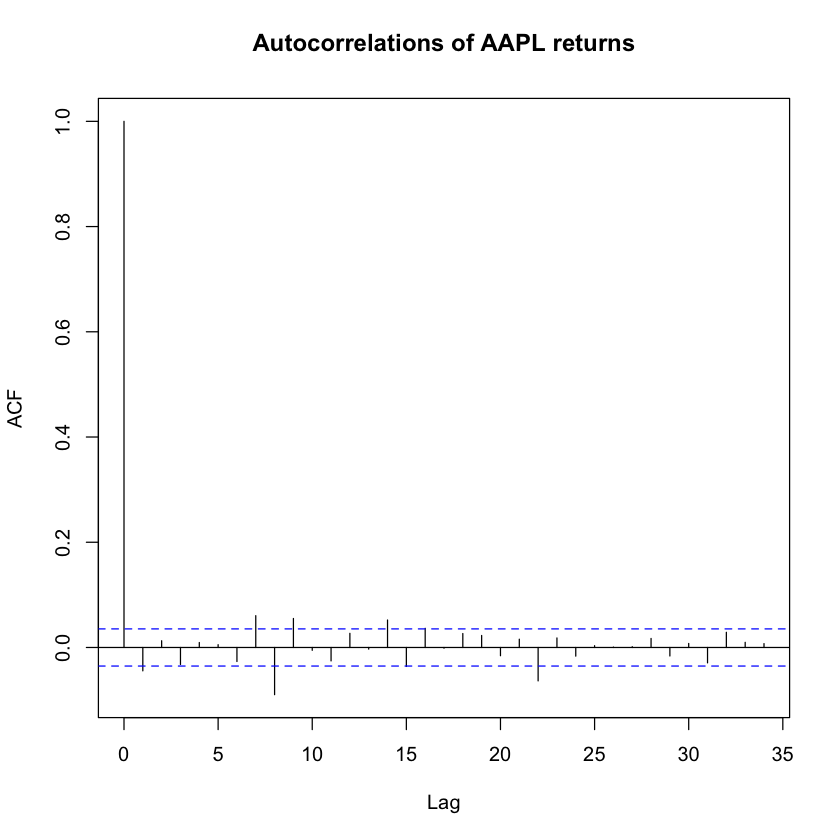

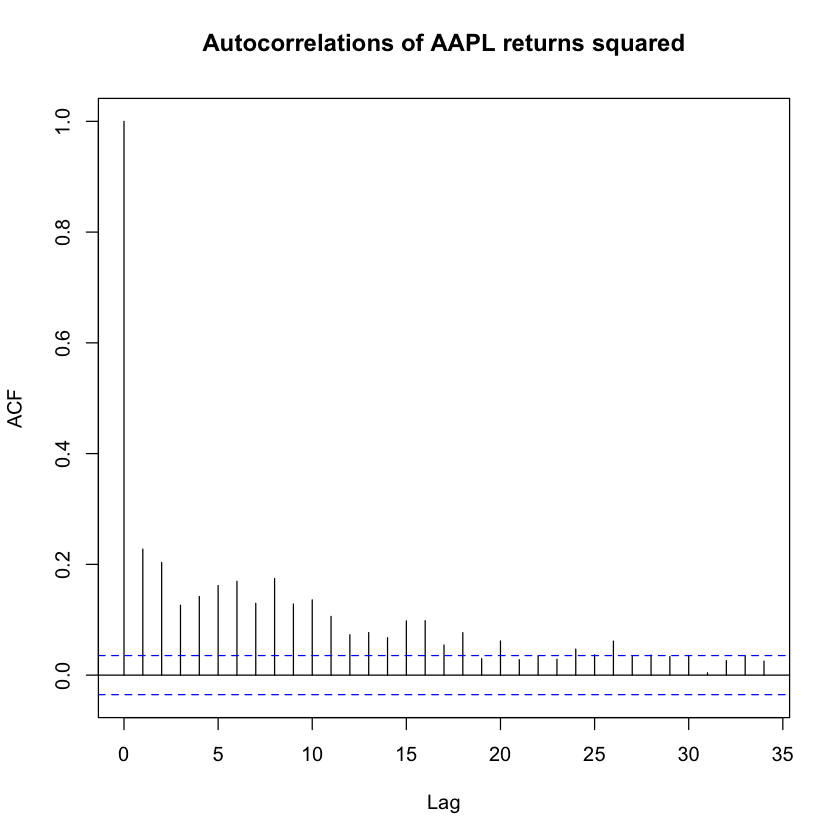

In [3]:
# Autocorrelations
acf(y, main = "Autocorrelations of AAPL returns")
acf(y^2, main = "Autocorrelations of AAPL returns squared")

In [4]:
# Create the specifications
default_spec <- ugarchspec()

# Fit the model to the data using ugarchfit
default_garch <- ugarchfit(spec = default_spec, data = y)

In [5]:
coef(default_garch)

mu           ar1           ma1         omega        alpha1 
 1.770379e-03  3.829061e-02 -2.749309e-02  1.849886e-05  1.166860e-01 
        beta1 
 8.259046e-01

In [6]:
likelihood(default_garch)

[1] 8306.952

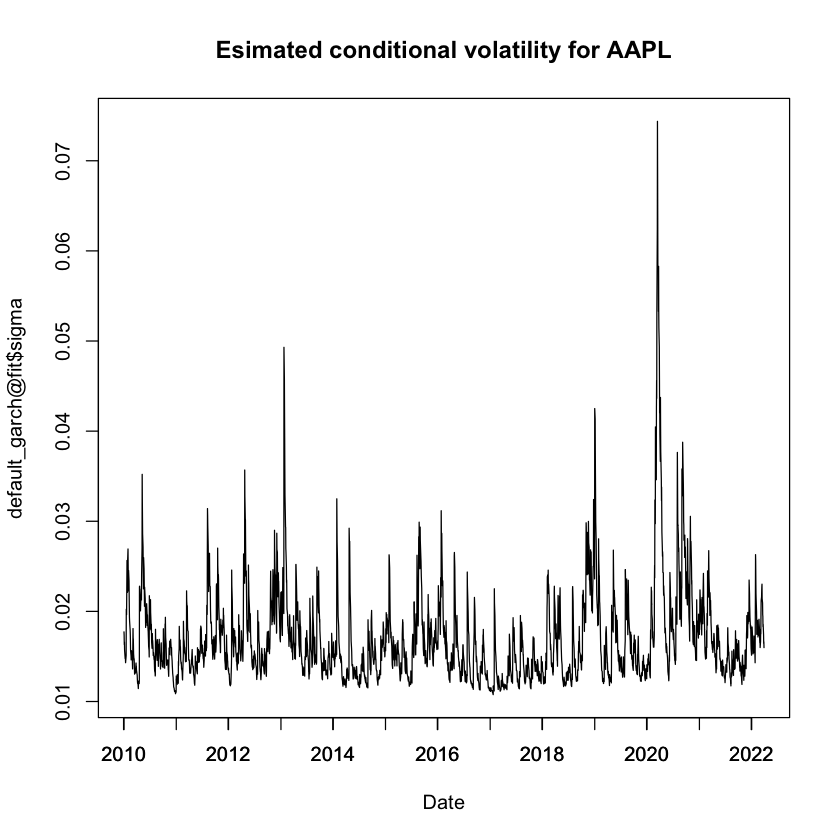

In [7]:
# Plotting the estimated conditional volatility
plot(dates,default_garch@fit$sigma, type = "l", main = "Esimated conditional volatility for AAPL", xlab = "Date")
axis.Date(1, at = seq(min(dates), max(dates), by = "years"))

In [8]:
# New specification
spec1 <- ugarchspec(
    variance.model = list(garchOrder = c(1,1)),
    mean.model = list(armaOrder = c(0,0), include.mean = FALSE)
)

# Fit the model
GARCH <- ugarchfit(spec = spec1, data = y)

In [9]:
coef(GARCH)

omega       alpha1        beta1 
1.827521e-05 1.022923e-01 8.394517e-01

In [10]:
# Specify tGARCH
spec3 <- ugarchspec(
    variance.model = list(garchOrder = c(1,1)),
    mean.model = list(armaOrder = c(0,0), include.mean = FALSE),
    distribution.model = "std"
)

# Fit the model
tGARCH <- ugarchfit(spec = spec3, data = y)

In [11]:
coef(tGARCH)

omega       alpha1        beta1        shape 
1.314997e-05 1.029605e-01 8.606478e-01 4.652624e+00

In [12]:
# Adding the p-value
p.value  <- 1 - pchisq(2*(likelihood(tGARCH)-likelihood(GARCH)), df = 1)
cat(" Likelihood of GARCH: ", round(likelihood(GARCH),2), "\n", 
    "Likelihood of tGARCH: ", round(likelihood(tGARCH),2), "\n",
   "2 * (Lu - Lr): ", round(2*(likelihood(tGARCH)-likelihood(GARCH)),2), "\n",
   "p-value:", p.value)

 Likelihood of GARCH:  8286.51 
 Likelihood of tGARCH:  8436.53 
 2 * (Lu - Lr):  300.05 
 p-value: 0

In [13]:
# Number of simulations
sim <- 1000

# Create vectors to hold the fitted parameters
omega_sim <- vector(length = sim)
alpha_sim <- vector(length = sim)
beta_sim <- vector(length = sim)

# Specify the GARCH we will use
spec <- ugarchspec(
    variance.model = list(garchOrder = c(1,1)),
    mean.model = list(armaOrder = c(0,0), include.mean = FALSE)
)

# Create the simulations
simulations <- ugarchsim(GARCH, m.sim = sim)

# Fit a GARCH for every simulation and store the parameter values
for (i in 1:sim) {
    # Fit the GARCH model
    temp <- ugarchfit(spec = spec1, data = simulations@simulation$seriesSim[,i])
    # Add parameters to vectors created
    omega_sim[i] <- unname(coef(temp)['omega'])
    alpha_sim[i] <- unname(coef(temp)['alpha1'])
    beta_sim[i] <- unname(coef(temp)['beta1'])
}

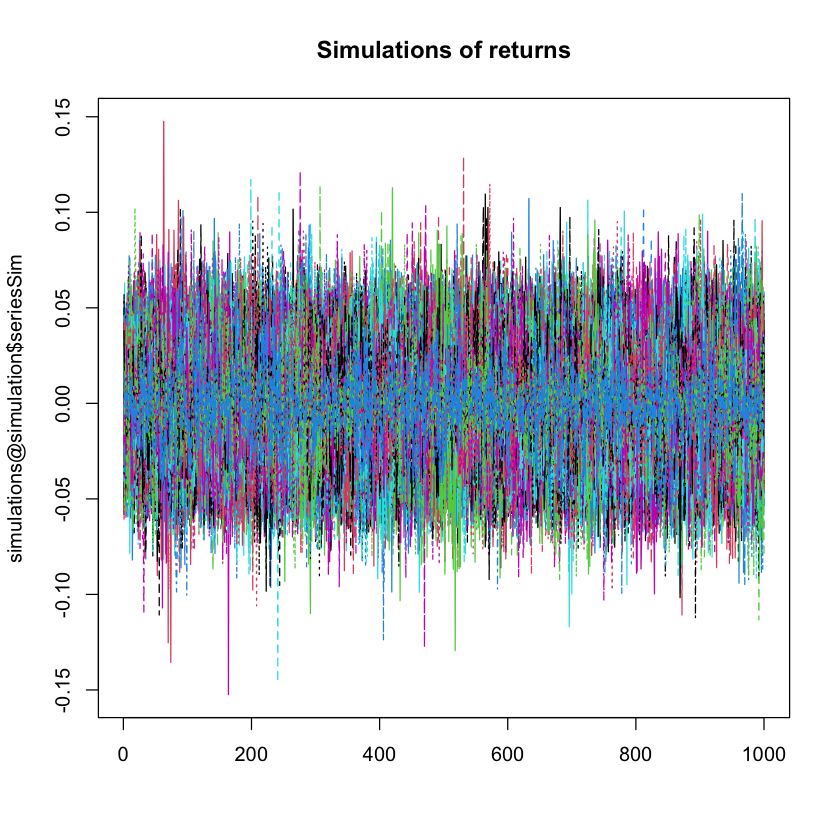

In [14]:
# Plot the simulated returns
matplot(simulations@simulation$seriesSim, type = "l",
       main = "Simulations of returns")

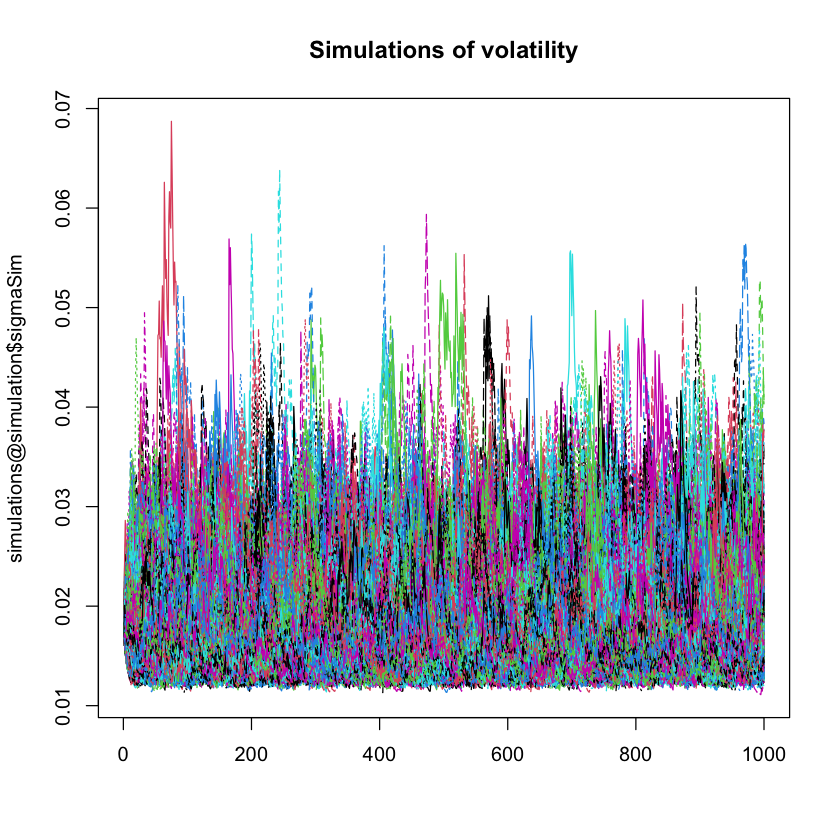

In [15]:
# Plot the simulated volatilities
matplot(simulations@simulation$sigmaSim, type = "l", 
       main = "Simulations of volatility")

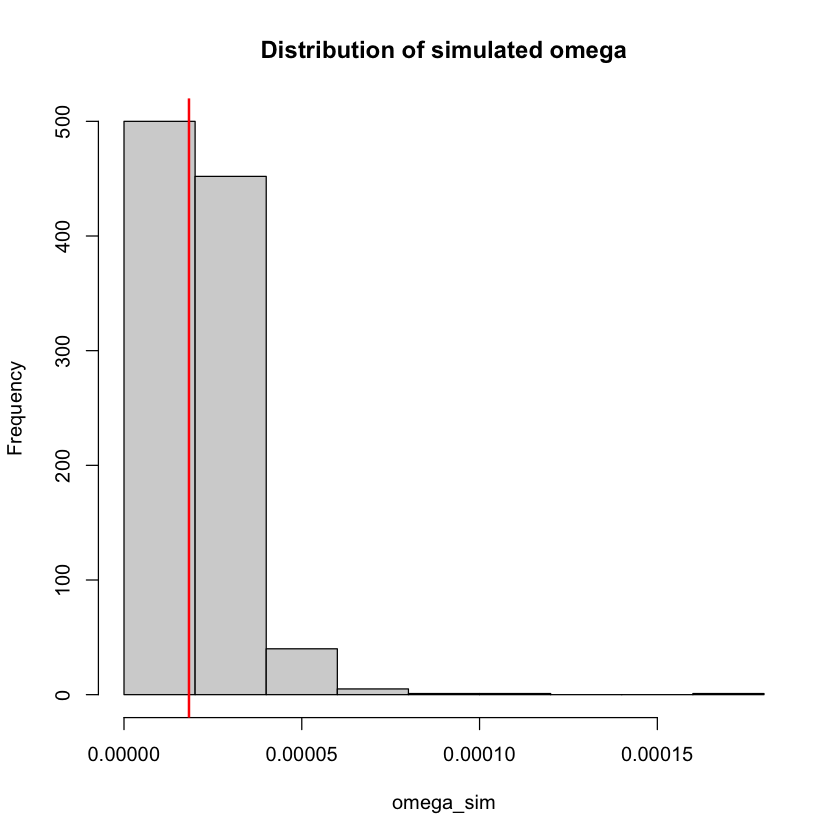

In [16]:
# Omega

# Distribution
hist(omega_sim, col = "lightgray", main = "Distribution of simulated omega")

# Adding a vertical line on the true parameter
abline(v = coef(GARCH)['omega'], col = "red", lwd = 2)

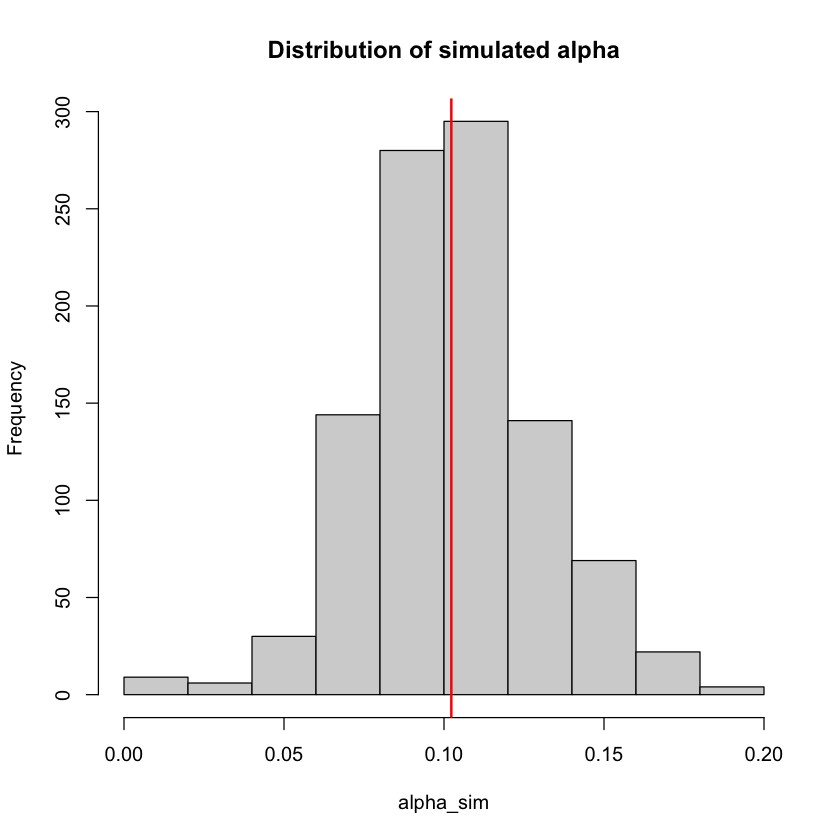

In [17]:
# Alpha

# Distribution
hist(alpha_sim, col = "lightgray", main = "Distribution of simulated alpha")

# Adding a vertical line on the true parameter
abline(v = coef(GARCH)['alpha1'], col = "red", lwd = 2)

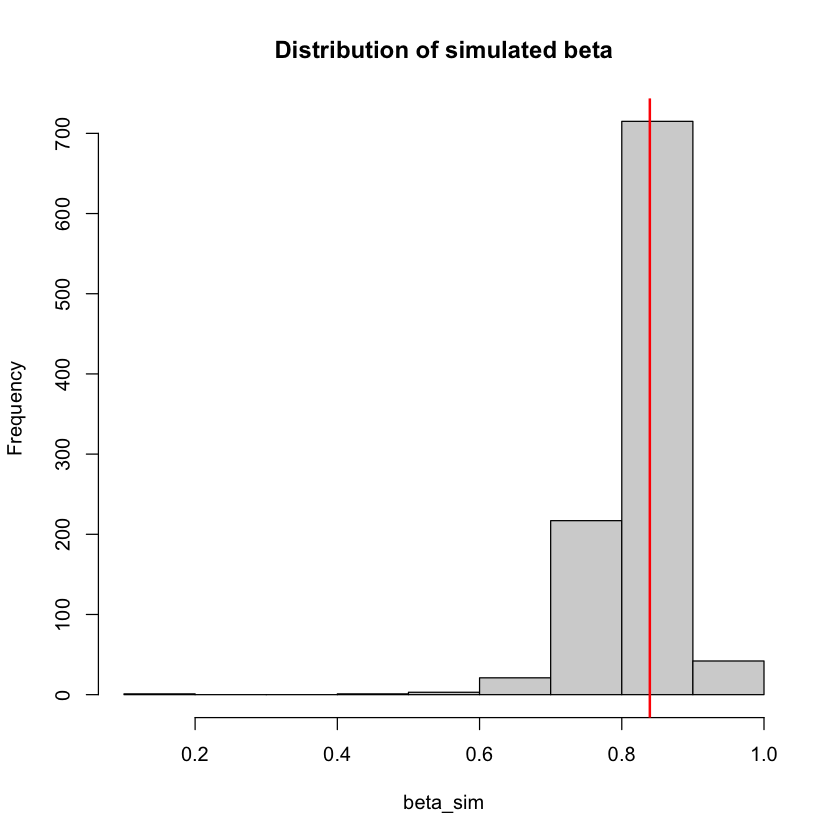

In [18]:
# Beta

# Distribution
hist(beta_sim, col = "lightgray", main = "Distribution of simulated beta")

# Adding a vertical line on the true parameter
abline(v = coef(GARCH)['beta1'], col = "red", lwd = 2)

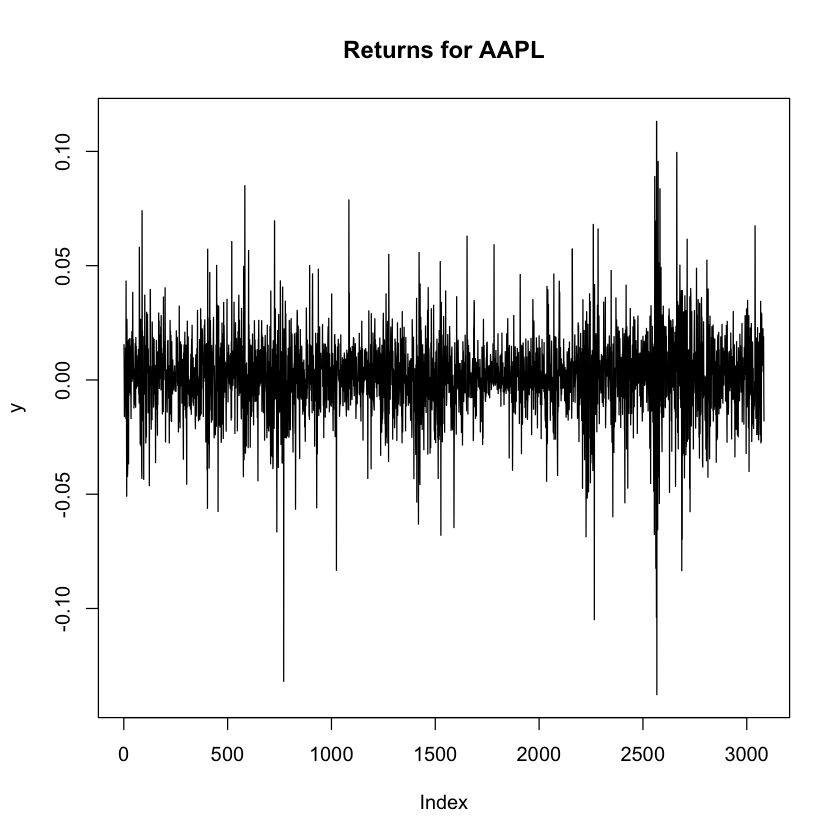

In [19]:
# Plot the returns
plot(y, type = "l", main = "Returns for AAPL")

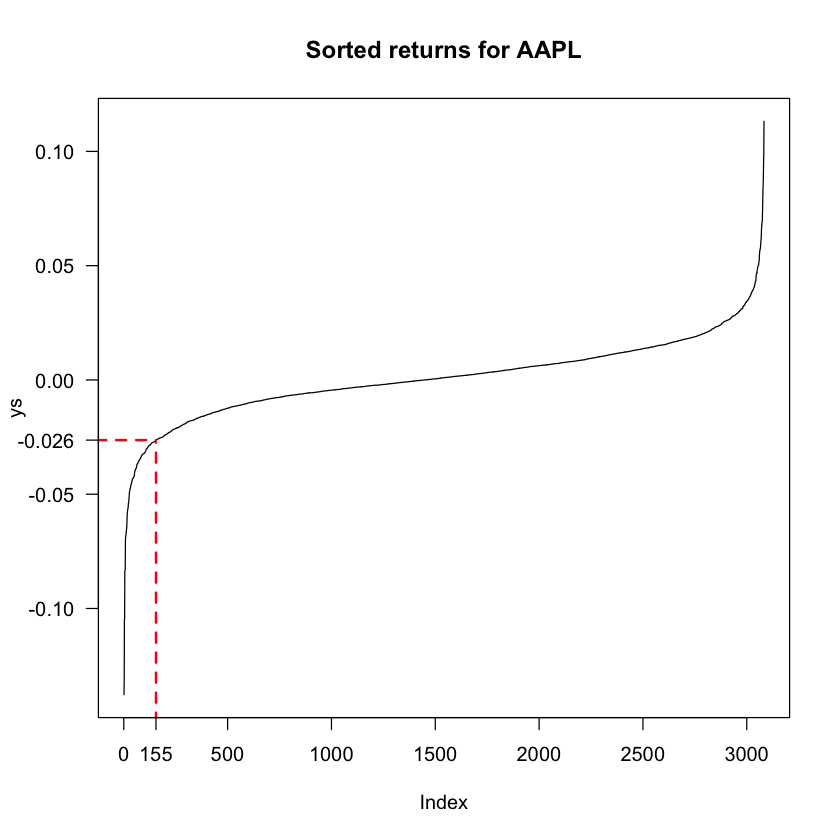

In [20]:
# Specify the probability p
p <- 0.05
# Assume we have a portfolio value of 1000 USD
portfolio <- 1000
# Sort the values in y using sort()
ys <- sort(y)
# Number of observations
n <- length(y)
# Round up
quant <- ceiling(n*p)
# Visually finding the 5% quantile
plot(ys, type = "l", main = "Sorted returns for AAPL", las = 1)

# Adding the segments
segments(x0 = quant, y0 = -0.5, y1 = ys[quant], lty = "dashed", lwd = 2, col ="red")
segments(x0 = -1000, y0 = ys[quant], x1 = quant, lty = "dashed", lwd = 2, col ="red")

# Adding ticks
axis(1, at = quant, label = quant)
axis(2, at = ys[quant], label = round(ys[quant],3), las = 1)

In [21]:
# Use it to calculate VaR, scaling for the portfolio value
VaR <- -ys[quant] * portfolio
VaR

[1] 26.32447

In [22]:
# For ES, we get the mean of observations up to the 5th quantile
ES <- -mean(ys[1:quant]) * portfolio
ES

[1] 40.57413

In [23]:
# Report our findings:
cat("We have", length(y), "observations on GE", "\n",
 p , "VaR is", VaR, "and ES is", ES, "on portfolio worth $", portfolio, "\n")

We have 3083 observations on GE 
 0.05 VaR is 26.32447 and ES is 40.57413 on portfolio worth $ 1000 


In [24]:
# Doing HS with the quantile() function
quant2 <- quantile(y,0.05)
quant2

# VaR
VaR <- -quant2*portfolio

cat("5% VaR is:", VaR)

5% 
-0.02631348

5% VaR is: 26.31348

In [25]:
VaR_sim <- vector(length = sim)
ES_sim <- vector(length = sim)

for (i in 1:sim){
    ys = sort(simulations@simulation$seriesSim[,i])
    portfolio <- 1000
    quant <- 50
    VaR <- -ys[quant] * portfolio
    ES <- -mean(ys[1:quant]) * portfolio
    VaR_sim[i] <- VaR
    ES_sim[i] <- ES
}

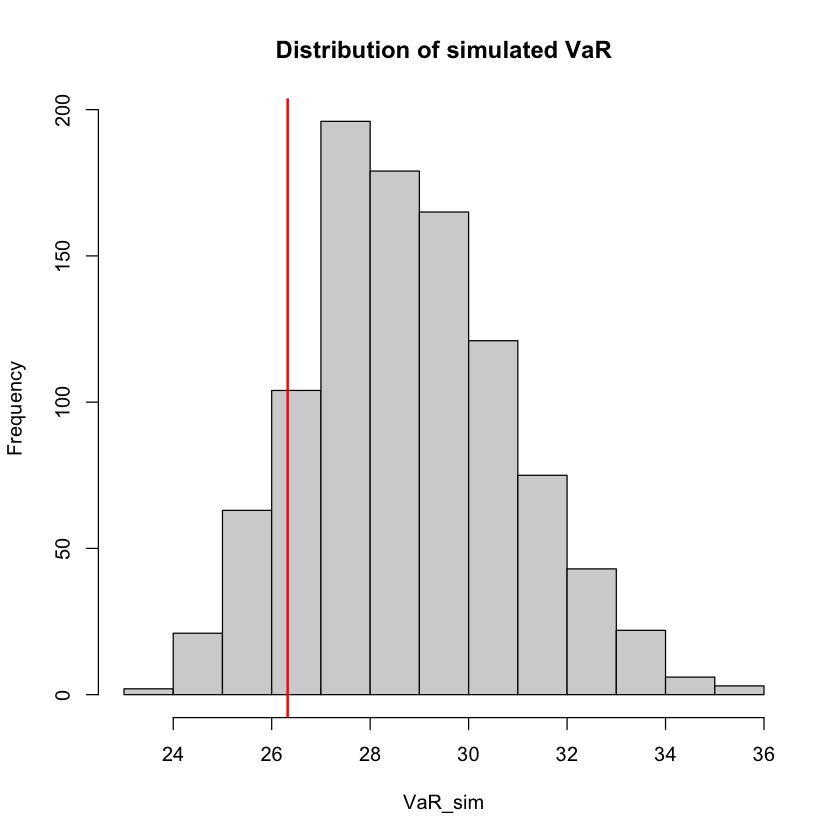

In [26]:
hist(VaR_sim, col = "lightgray", main = "Distribution of simulated VaR")
abline(v = 26.324468, col = "red", lwd = 2)

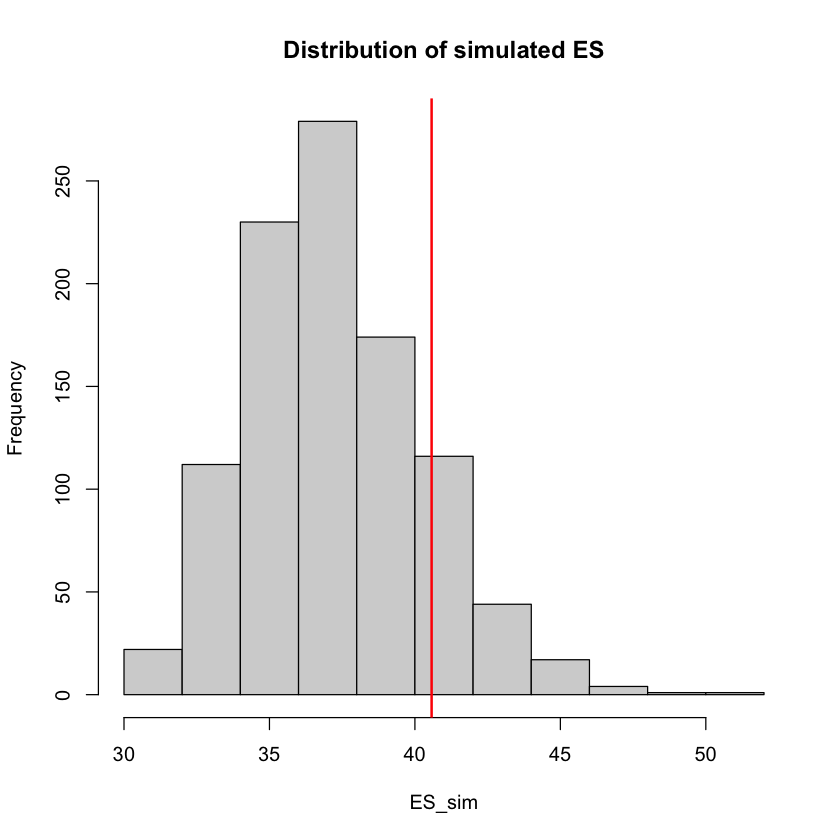

In [27]:
hist(ES_sim, col = "lightgray", main = "Distribution of simulated ES")
abline(v = 40.574130, col = "red", lwd = 2)

In [28]:
V_mu = mean(VaR_sim)
V_s = sd(VaR_sim)
print(V_mu)
print(V_mu-1.96*V_s/sqrt(sim))
print(V_mu+1.96*V_s/sqrt(sim))

[1] 28.77979
[1] 28.65073
[1] 28.90886


In [29]:
E_mu = mean(ES_sim)
E_s = sd(ES_sim)
print(E_mu)
print(E_mu-1.96*E_s/sqrt(sim))
print(E_mu+1.96*E_s/sqrt(sim))

[1] 37.27125
[1] 37.08261
[1] 37.45989
